This jupyter notebook shows the code used for the analysis:  
1. Proportion analysis using `statsmodels` implementaiton of MixedLM;
2. Differential gene expression analysis using pydeseq2.

In [2]:
# libraries to work with single-cell data and tables
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import os

# for compositional analysis
# load twice
import pertpy as pt

# for differential gene expression
import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import adjustText
from adjustText import adjust_text
import decoupler as dc

# for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.rcdefaults()
sc.set_figure_params({'facecolor':'white'})
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 100

In [3]:
# list versions of used packages
{'scanpy': sc.__version__, 
 'pandas': pd.__version__, 
 'numpy': np.__version__,
 'anndata': anndata.__version__,
 'pertpy': pt.__version__,
 'pydeseq2': pydeseq2.__version__,
 'decoupler': dc.__version__,
 'adjustText': adjustText.__version__,
 'seaborn': sns.__version__,
 'matplotlib': matplotlib.__version__
}

{'scanpy': '1.10.2',
 'pandas': '2.2.2',
 'numpy': '1.26.4',
 'anndata': '0.10.8',
 'pertpy': '0.10.0',
 'pydeseq2': '0.5.0',
 'decoupler': '1.8.0',
 'adjustText': '1.2.0',
 'seaborn': '0.13.2',
 'matplotlib': '3.9.2'}

# Read test data (part of the real dataset generated in this study with up to 100 cells per celltype)

In [4]:
adata = sc.read_h5ad('test_data/test.h5ad')
adata.uns['log1p'] = {'base':None}

`sample`: sample annotation  
`patient`: patient annotation  
`origin`: origin of biospecimen  
`type`: condition, e.g. aneurysm or normal (=mild aneurysm)  
`refined_annotation`: annotation

In [29]:
adata.obs.columns

Index(['sample', 'patient', 'origin', 'type', 'n_genes_by_counts',
       'total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'n_genes', 'total_counts_mt',
       'pct_counts_mt', 'low', 'labels_low', 'refined_annotation', 'c'],
      dtype='object')

In [26]:
adata[1,:].X.sum()

4107.397

In [27]:
adata.layers['counts'][1,:].sum()

1794.0

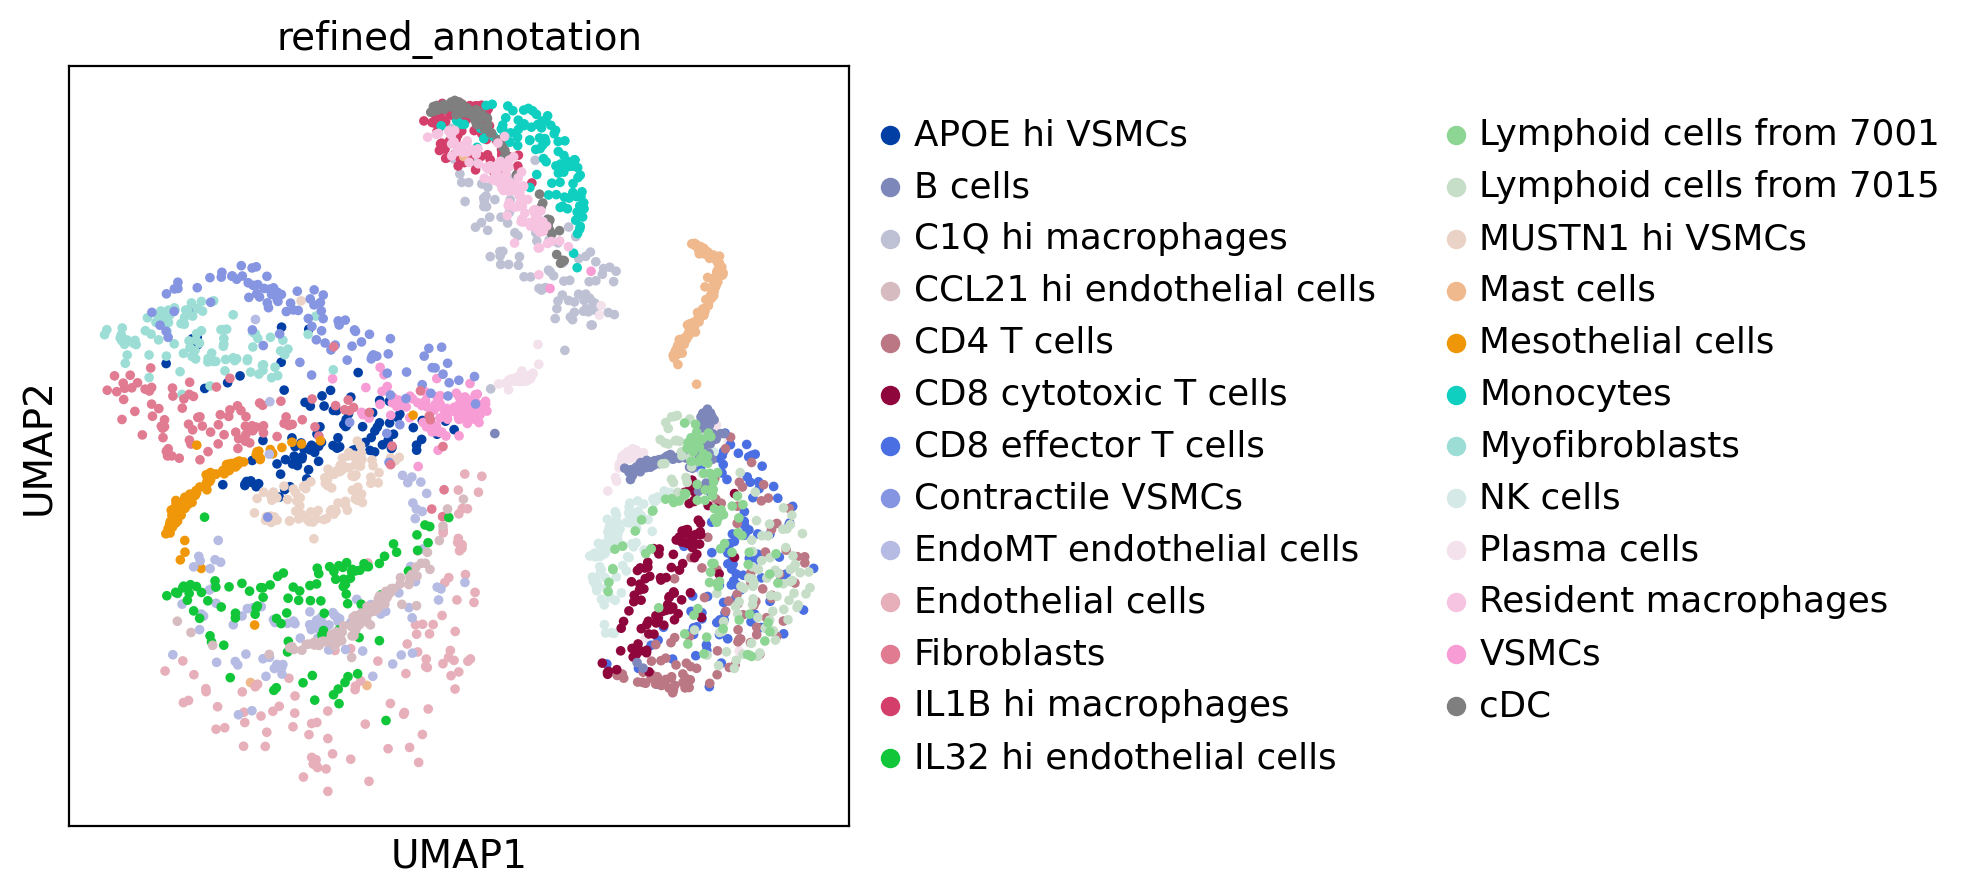

In [22]:
sc.pl.umap(adata, color=['refined_annotation'])

Real dataset had batch effect by sample. It was fixed using `sc.external.pp.bbknn` instead of `sc.pp.neighbors`.  
The example dataset is already normalized and log-transformed. It also has counts in `.layers['counts']`.

# Compositional analysis, scCODA

In [5]:
sccoda_model = pt.tl.Sccoda()

In [6]:
sccoda_data = sccoda_model.load(
    adata=adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="refined_annotation",
    sample_identifier="sample",
    covariate_obs=["type"],
)

/hpc/users/radkee01/.local/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:1678: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


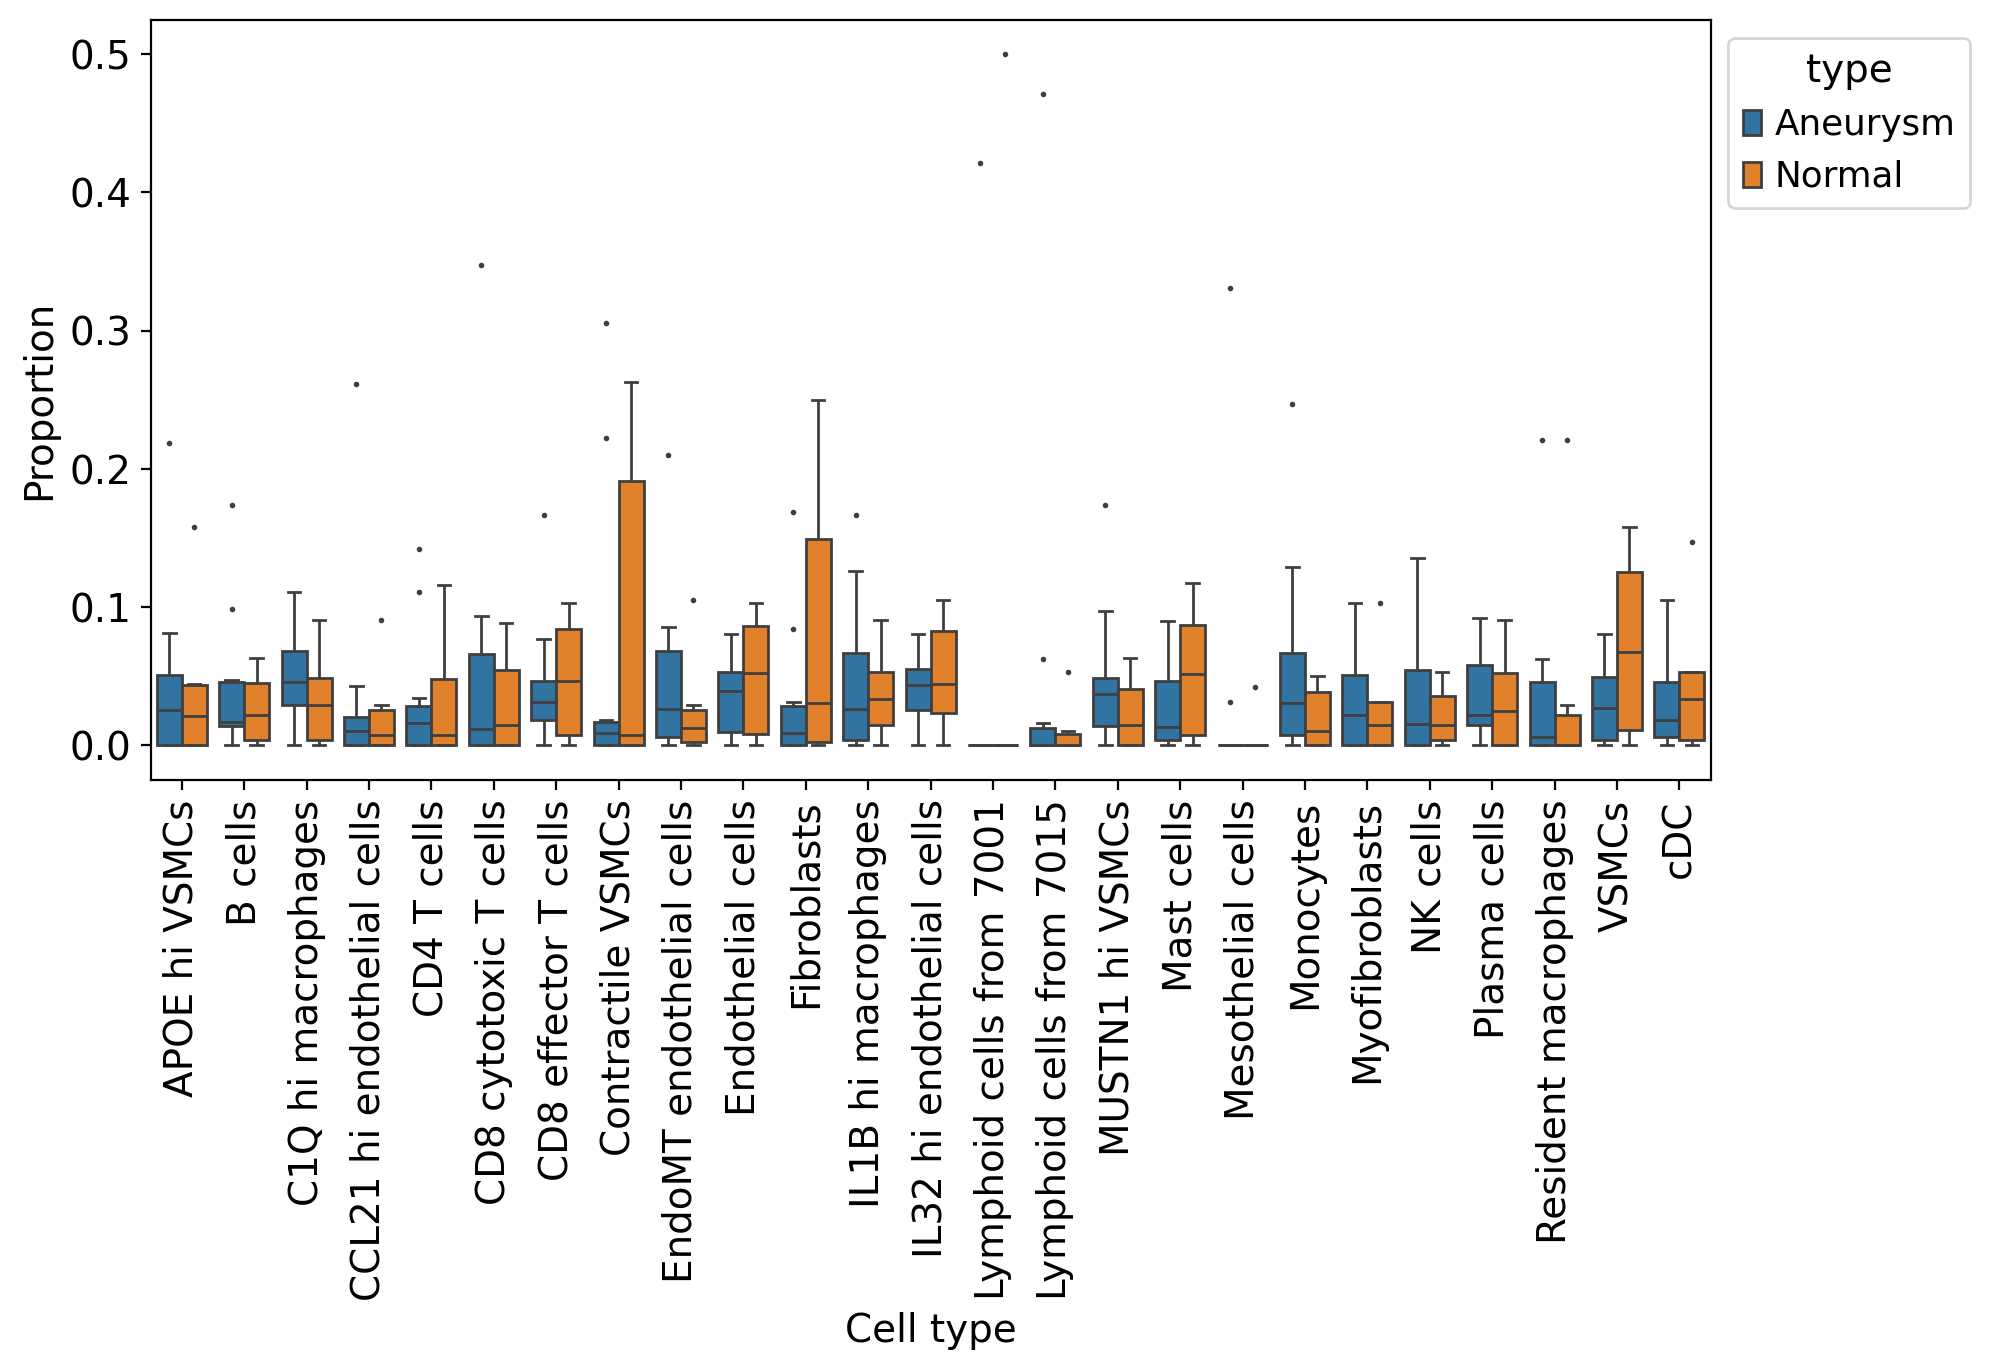

In [9]:
sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="type",
    figsize=(10,5),
    add_dots=False,
    return_fig=True,
    palette='tab10'
)

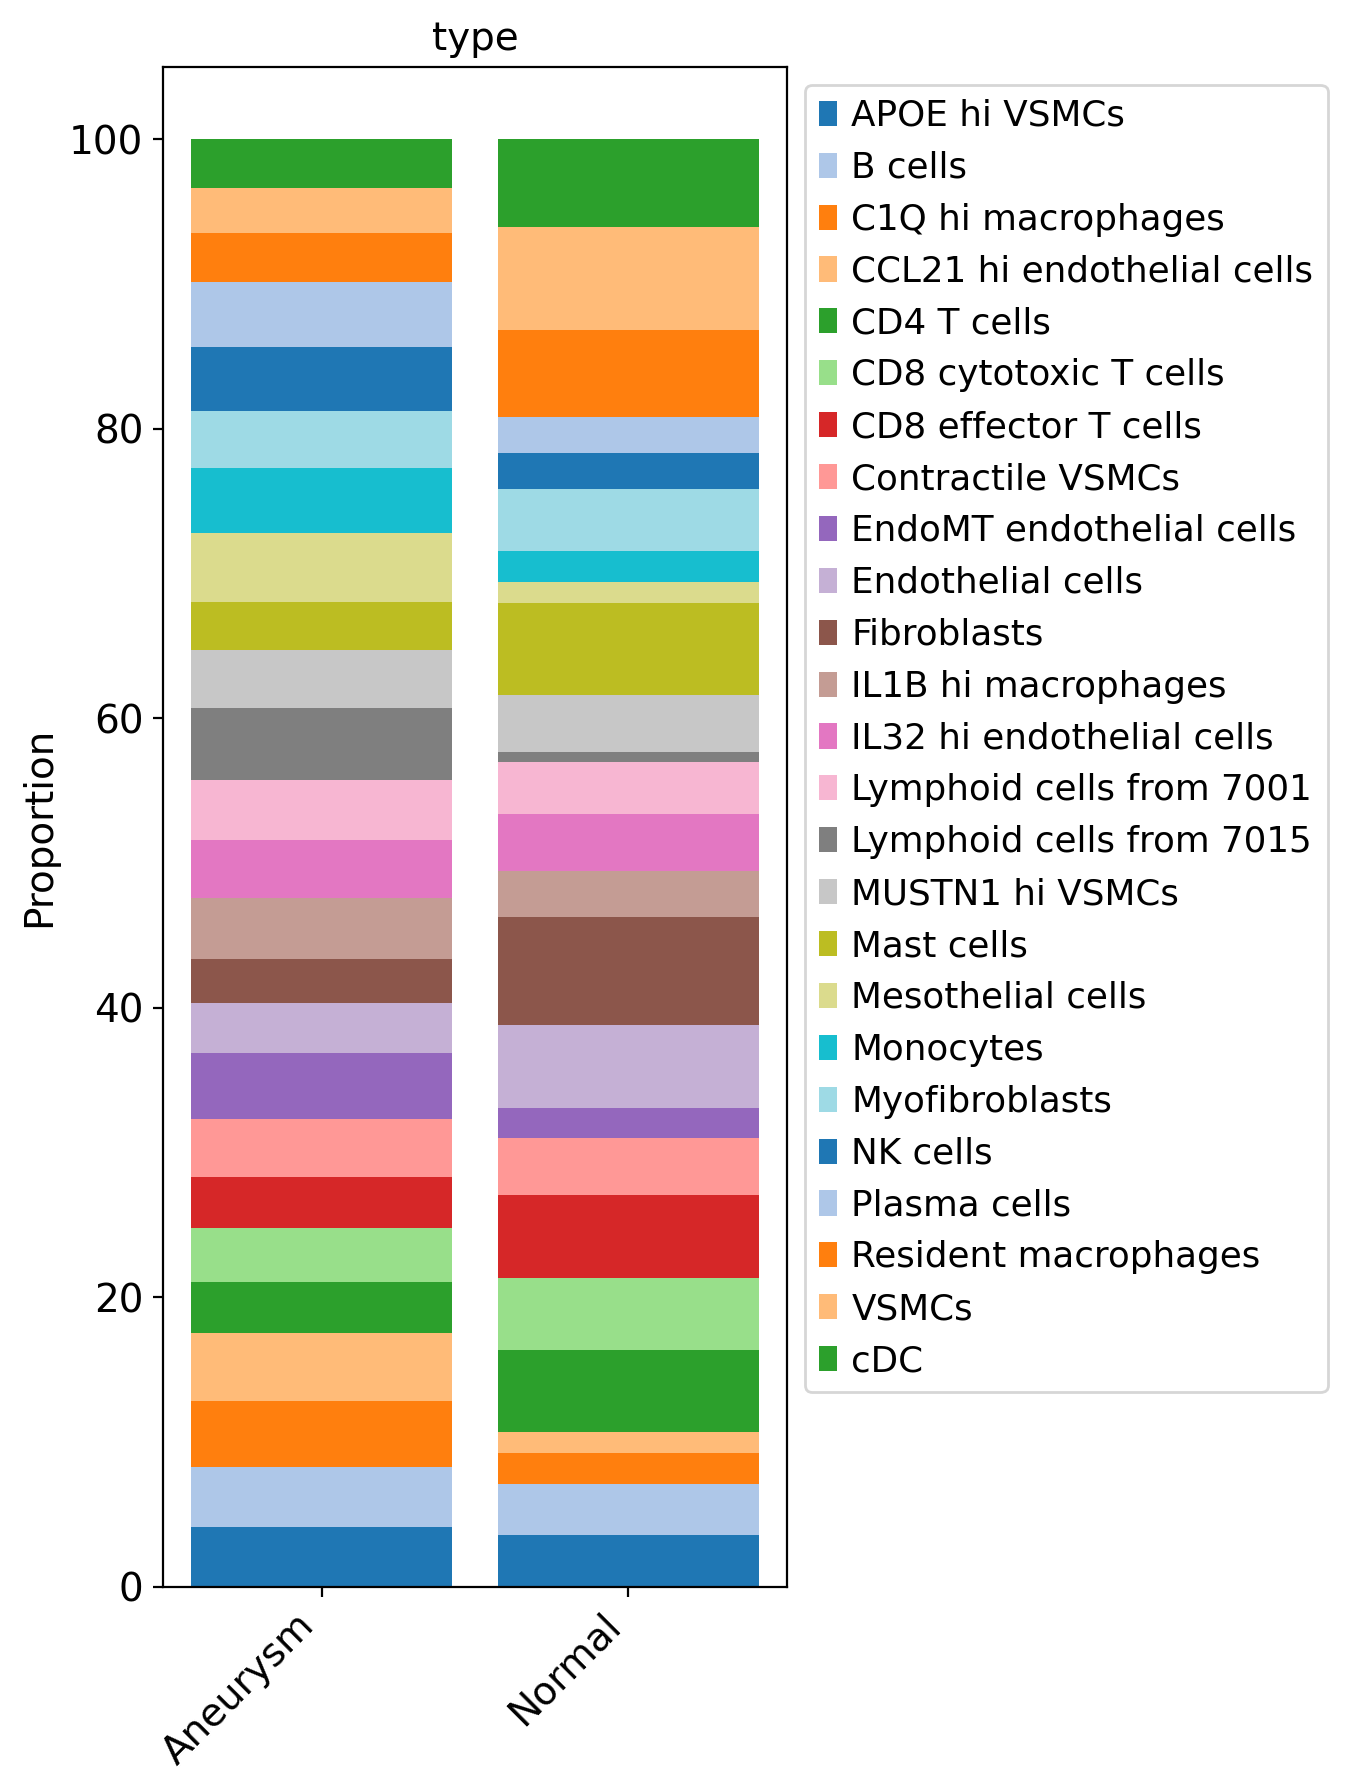

In [10]:
sccoda_model.plot_stacked_barplot(
    sccoda_data, modality_key="coda", 
    feature_name="type", figsize=(4, 10),
    return_fig=True
)

run regression

In [13]:
# in this example we need to increase automatic_reference_absence_threshold to 0.2,
# in real run we set it up to the deafult value of 0.05
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="C(type, Treatment('Normal'))",
    automatic_reference_absence_threshold=0.2,
)

• Automatic reference selection! Reference cell type set to IL32 hi endothelial cells
• Zero counts encountered in data! Added a pseudocount of 0.5.


In [14]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234)

sample: 100%|██████████| 11000/11000 [00:57<00:00, 192.14it/s, 63 steps of size 4.94e-02. acc. prob=0.88] 


In [15]:
sccoda_model.credible_effects(sccoda_data, modality_key="coda")

Covariate                                 Cell Type                 
C(type, Treatment('Normal'))[T.Aneurysm]  APOE hi VSMCs                 False
                                          B cells                       False
                                          C1Q hi macrophages            False
                                          CCL21 hi endothelial cells    False
                                          CD4 T cells                   False
                                          CD8 cytotoxic T cells         False
                                          CD8 effector T cells          False
                                          Contractile VSMCs             False
                                          EndoMT endothelial cells      False
                                          Endothelial cells             False
                                          Fibroblasts                   False
                                          IL1B hi macrophages           F

if at least one positive credible effect would be found, then we could proceed to plotting barplot

In [17]:
# sccoda_model.plot_effects_barplot(data=sccoda_data, 
#                                   modality_key="coda",
#                                   return_fig=True,
#                                   covariates="type")

# Differential gene expression using pydeseq2

## Calculate and save .csv

In [194]:
def filter_cell_gene_matrix(adata: anndata.AnnData,
                            celltype_column: str
                            ) -> anndata.AnnData:

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=0)
    adata=adata[:,adata.var['n_cells']/adata.shape[0]>0.05]

    print('Filtering out (1) cells with less than 200 genes, '\
          f'(2) genes expressed in less than 5 % of cells in {celltype_column}.')
    print(celltype_column, adata.shape)
    
    return adata
    

def calculate_pseudobulk(adata: anndata.AnnData,
                         celltype_column: str,
                         sample_column: str,
                         groups_column: str,
                         condition_ref: str,
                         condition_test: str,
                         output_folder: str,
                         skip_checks: bool=False,
                         save: bool=False
                         ) -> None:
    
    celltypes = adata.obs[celltype_column].unique()
    
    for celltype in celltypes:
        
        celltype_adata = adata[adata.obs[celltype_column]==celltype]
        celltype_adata = filter_cell_gene_matrix(celltype_adata, celltype)
        
        psb = dc.get_pseudobulk(adata=celltype_adata,
                                sample_col=sample_column,
                                groups_col=groups_column,
                                mode='sum',
                                min_cells=5,
                                min_prop=0,
                                min_smpls=0,
                                skip_checks=skip_checks)

        psb = psb[psb.obs[psb.obs.psbulk_n_cells!=0].index, :]
        
        if len(psb.obs[groups_column].unique())<2: 
            print(f'{celltype} is represented only in one group.')
            continue

        try:
            dds = DeseqDataSet(adata=psb,
                               design_factors=[groups_column],
                               ref_level=[groups_column,condition_ref],
                               quiet=False)
        except:
            try:
                psb.X = psb.X.astype(int)
                dds = DeseqDataSet(adata=psb,
                                   design_factors=[groups_column],
                                   ref_level=[groups_column,condition_ref],
                                   quiet=False)
            except Exception as e: 
                print(f'{celltype} is failed. {celltype_adata.shape}', e)
                continue
                
        try: dds.deseq2()
        except Exception as e: print(e); continue
        
        contrast = [groups_column, condition_test.replace('_','-'), 
                    condition_ref.replace('_','-')]
        stat_res = DeseqStats(dds=dds, contrast=contrast)
        stat_res.summary()
        res = stat_res.results_df

        print(f'Cell type = {celltype}, '\
              'number of significant (padj<0.05) gene findings='\
              f'{res.loc[res.padj<0.05].shape[0]}')
        
        if save:
            os.makedirs(f'{output_folder}',exist_ok=True)
            res.to_csv(f'{output_folder}/{celltype}.csv')

In [51]:
adata_counts = adata.copy()
adata_counts.X = adata_counts.layers['counts']

# should be a whole number -- counts, NOT log1p
adata_counts[1,:].X.sum()

1794.0

In [52]:
calculate_pseudobulk(adata=adata_counts,
                     celltype_column='refined_annotation',
                     sample_column='sample',
                     groups_column='type',
                     condition_ref='Normal',
                     condition_test='Aneurysm',
                     output_folder='deseq2_test',
                     skip_checks=True,
                     save=True)

## Plot and save .pdf

In [53]:
def add_color_significance(df: pd.DataFrame
                           ) -> pd.DataFrame:
    red = ((df.padj<0.05)&(df.log2FoldChange>1)).map({True:'red',False:np.nan})
    blue = ((df.padj<0.05)&(df.log2FoldChange<-1)).map({True:'blue'})
    colors = (red.combine_first(blue)).fillna('gray')
    df['colors'] = colors
    return df

def plot_volcano(deseq2_folder: str,
                 volcano_folder: str,
                 threshold: int=None
                 ) -> None:
    
    if (os.path.exists(deseq2_folder)) and (len(os.listdir(deseq2_folder))>0): 
        pass
    else: 
        print(f'{deseq2_folder} folder does not exist. Run DGE first.')
        return None
    
    print('Plotting volcano plots for:')
    
    for celltype in os.listdir(deseq2_folder):
        
        if celltype.endswith('.csv'): celltype = celltype[:-4]
        else: continue

        try: 
            deg_df = pd.read_csv(f'{deseq2_folder}/{celltype}.csv',index_col=0)
        except Exception as e: 
            print(celltype, e); continue

        deg_df['-log10pv'] = -np.log10(deg_df['padj'])
        deg_df = add_color_significance(deg_df)
        
        # filtering technical artifacts
        if threshold is not None: 
            deg_df = deg_df.loc[abs(deg_df.log2FoldChange)<threshold]

        # plot volcano
        print(f'- {celltype}')
        ax = \
        deg_df.plot.scatter(x='log2FoldChange', y='-log10pv',
                            s=10, c='colors', alpha=.5)

        ax.set_ylabel('-log10(p-value)')
        ax.set_title(celltype)

        red = deg_df[deg_df['colors']=='red'].index
        blue = deg_df[deg_df['colors']=='blue'].index

        # highlight top 10 genes on over- and underrepresented sides
        redtoshow = \
        deg_df.reindex(red)['log2FoldChange'].sort_values().index.tolist()[-10:]
        bluetoshow = \
        deg_df.reindex(blue)['log2FoldChange'].sort_values().index.tolist()[:10]
        toshow = redtoshow+bluetoshow

        texts = [ax.text(deg_df.loc[i,'log2FoldChange'], 
                         deg_df.loc[i,'-log10pv'], 
                         i, fontsize=8) \
                 for i in toshow]
        adjust_text(texts)

        # save results as .pdf figures
        os.makedirs(f'{volcano_folder}', exist_ok=True)
        plt.savefig(f'{volcano_folder}/{celltype}.pdf', 
                    format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

In [54]:
plot_volcano(deseq2_folder='deseq2_test',
             volcano_folder='deseq2_test_figures')